In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pylab as plt
import seaborn as sn
import numpy as np

In [2]:
df = pd.read_csv("data/sp500/csv/AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by='Date')


### Visual Stationarity

In [4]:
# Assuming df is your DataFrame and 'Close' is the column of interest
half = int(len(df) / 2)
first_half = df['Close'].iloc[:half]
second_half = df['Close'].iloc[half:]

# Calculate rolling statistics
window_size = 12  # This is an arbitrary value; you might need to adjust it
first_half_rolling_mean = first_half.rolling(window=window_size).mean()
first_half_rolling_std = first_half.rolling(window=window_size).std()

second_half_rolling_mean = second_half.rolling(window=window_size).mean()
second_half_rolling_std = second_half.rolling(window=window_size).std()


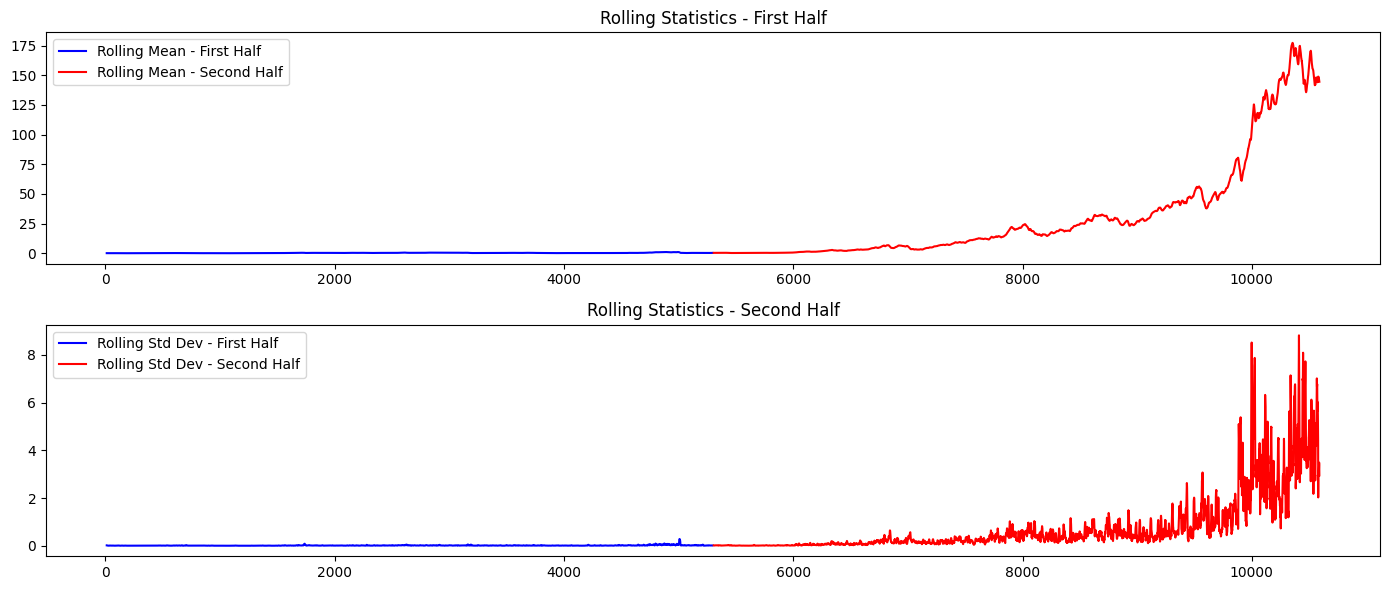

In [5]:
import matplotlib.pyplot as plt

# Plot Rolling Statistics for the First Half
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(first_half_rolling_mean, label='Rolling Mean - First Half', color='blue')
plt.plot(second_half_rolling_mean, label='Rolling Mean - Second Half', color='red')
plt.title('Rolling Statistics - First Half')
plt.legend()

# Plot Rolling Statistics for the Second Half
plt.subplot(2, 1, 2)
plt.plot(first_half_rolling_std, label='Rolling Std Dev - First Half', color='blue')
plt.plot(second_half_rolling_std, label='Rolling Std Dev - Second Half', color='red')
plt.title('Rolling Statistics - Second Half')
plt.legend()

plt.tight_layout()
plt.show()


### Statistical Stationarity

In [6]:
close_prices = df['Close']

In [7]:
result = adfuller(close_prices.dropna())  # Drop NA values if present
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.301392
p-value: 0.998956
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [8]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Num Lags: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(close_prices)


KPSS Statistic: 7.9526701498163845
p-value: 0.01
Num Lags: 60
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/Users/francescomattioli/opt/miniconda3/envs/DataMining/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Make the series Stationary

In [9]:
df["close_diff"] = df["Close"].diff()


In [12]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit a linear model
X = np.arange(len(df)).reshape(-1, 1)
y = df["Close"].values
model = LinearRegression()
model.fit(X, y)

# Calculate the trend
trend = model.predict(X)

# Detrend the series
df["close_detrend"] = y - trend

ModuleNotFoundError: No module named 'sklearn'

In [10]:
df["close_log"] = np.log(df["Close"])


KeyError: 'close_detrend'

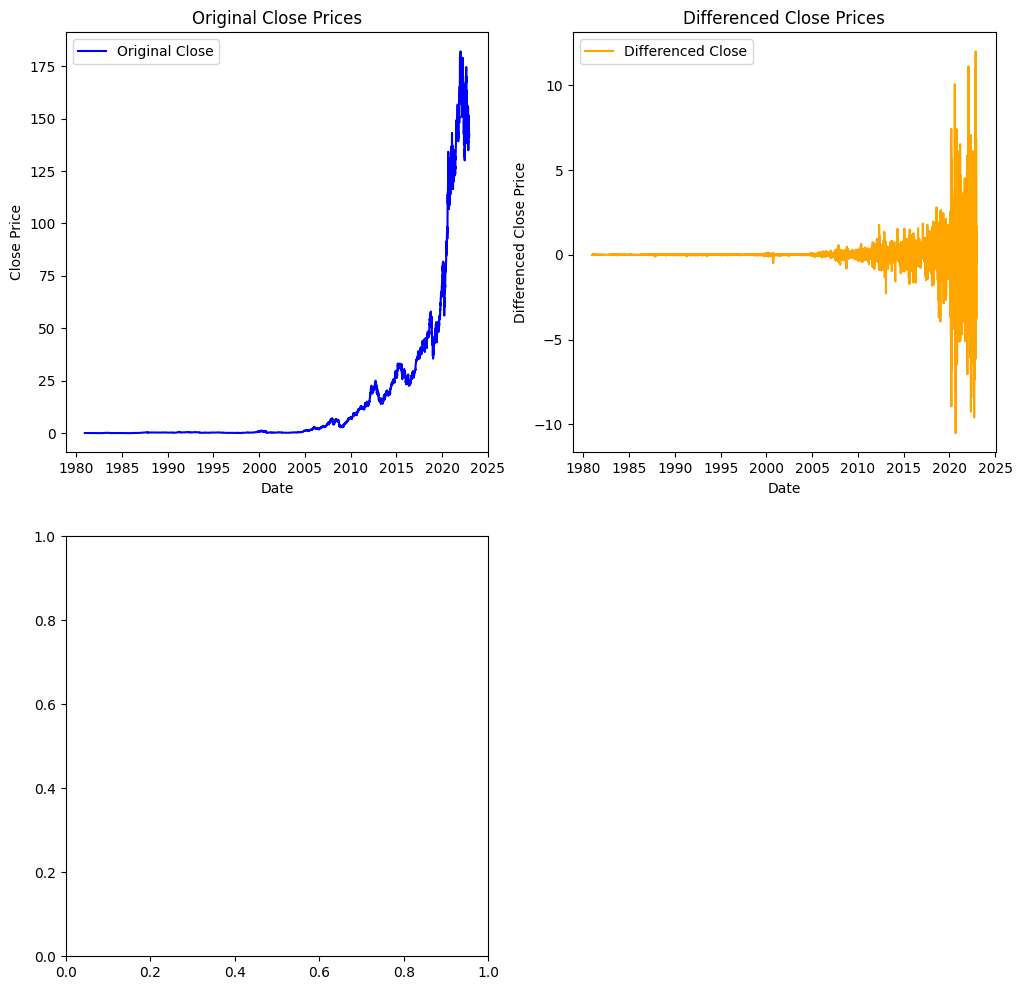

In [11]:
import matplotlib.pyplot as plt

# Plot the original 'Close' prices
plt.figure(figsize=(12, 12))  # Adjusted for larger size
plt.subplot(2, 2, 1)  # Two rows, two columns, first plot
plt.plot(df['Date'], df['Close'], label='Original Close', color='blue')
plt.title('Original Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot the differenced 'Close' prices
plt.subplot(2, 2, 2)  # Two rows, two columns, second plot
plt.plot(df['Date'], df['close_diff'], label='Differenced Close', color='orange')
plt.title('Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()

# Plot the 'Model Fitting Close' prices (assuming this column exists in df)
plt.subplot(2, 2, 3)  # Two rows, two columns, third plot
plt.plot(df['Date'], df['close_detrend'], label='Model Fitting Close', color='red')
plt.title('Model Fitting Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot the 'Log Close' prices (assuming this column exists in df)
plt.subplot(2, 2, 4)  # Two rows, two columns, fourth plot
plt.plot(df['Date'], df['close_log'], label='Log Close', color='green')
plt.title('Log Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()  # Adjusts the plots to fit visually better
plt.show()


### Check Stationarity on new Close Columns

In [12]:
def ADF_check(column):
    close_prices = df[column]
    result = adfuller(close_prices.dropna())  # Drop NA values if present
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [13]:
df['close_diff'].dropna(inplace=True)
ADF_check('close_diff')

ADF Statistic: -17.801984
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [14]:
ADF_check('close_log')

ADF Statistic: 0.340529
p-value: 0.979129
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Apply Fractional Differencing

In [7]:
from fracdiff.sklearn import FracdiffStat

In [10]:

# Initialize the FracdiffStat object
fd = FracdiffStat()

# Apply fractional differencing
fracdiff_series = fd.fit_transform(df[['Close']].values)

# Convert the result back to a DataFrame for easier handling
fracdiff_df = pd.DataFrame(fracdiff_series, columns=['FracDiffClose'])

# Combine with the original data for comparison
df = pd.concat([df, fracdiff_df], axis=1)

# Display the first few rows to check
print(df.head())

        Date       Low      Open     Volume      High     Close  \
0 1980-12-12  0.128348  0.128348  469033600  0.128906  0.128348   
1 1980-12-15  0.121652  0.122210  175884800  0.122210  0.121652   
2 1980-12-16  0.112723  0.113281  105728000  0.113281  0.112723   
3 1980-12-17  0.115513  0.115513   86441600  0.116071  0.115513   
4 1980-12-18  0.118862  0.118862   73449600  0.119420  0.118862   

   Adjusted Close  FracDiffClose  FracDiffClose  
0        0.099874       0.128348       0.128348  
1        0.094663       0.009348       0.009348  
2        0.087715      -0.000742      -0.000742  
3        0.089886       0.007595       0.007595  
4        0.092492       0.007730       0.007730  


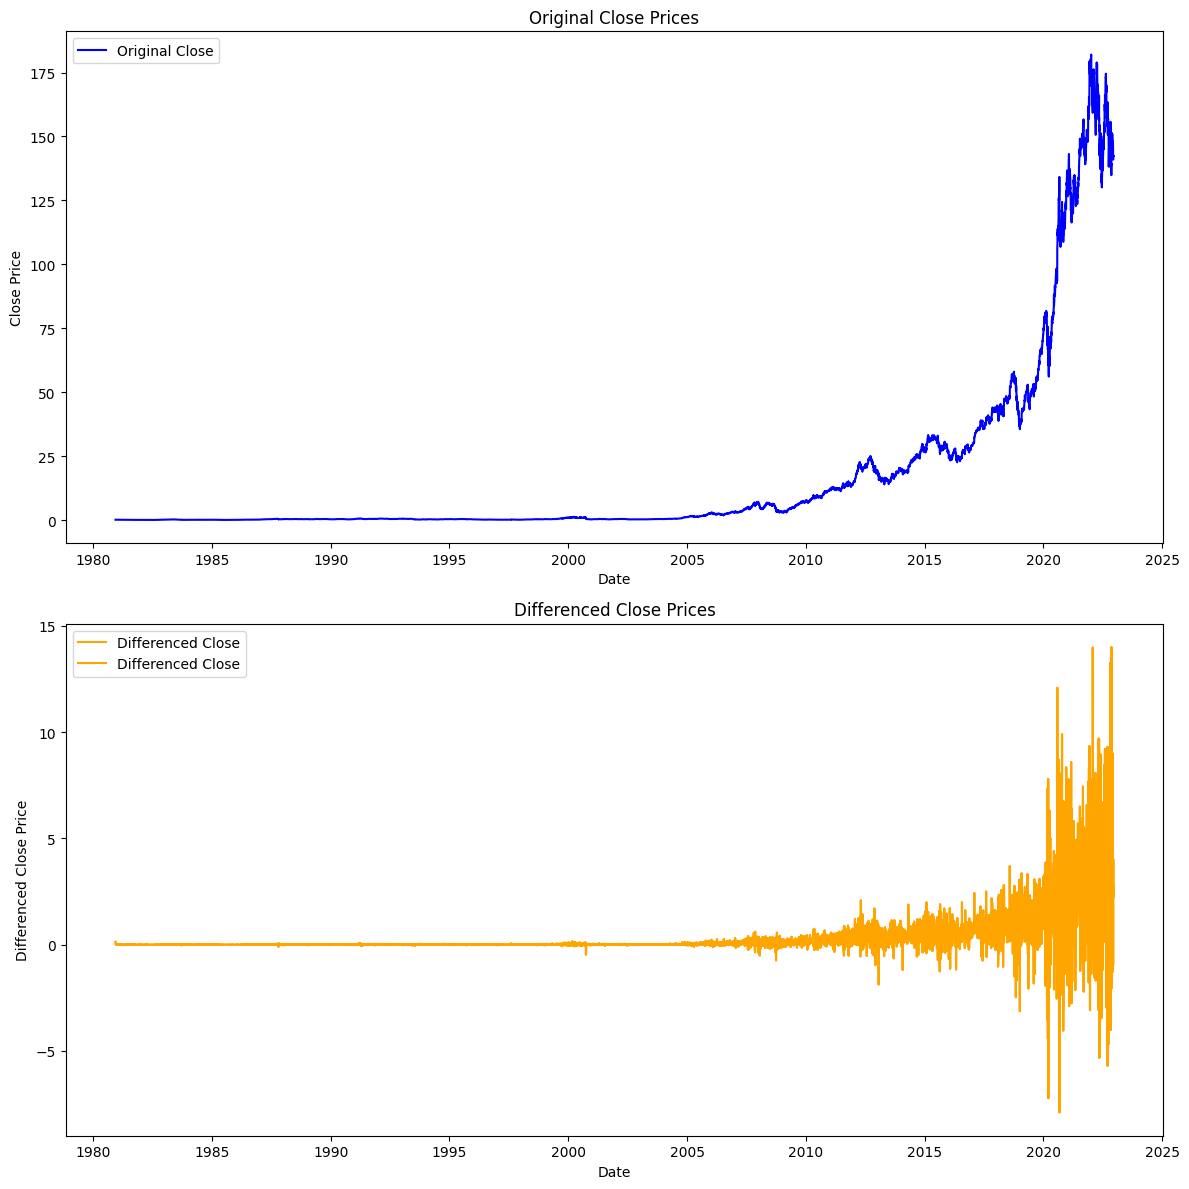

In [13]:
plt.figure(figsize=(12, 12))  # Adjusted for larger size
plt.subplot(2, 1, 1)  # Two rows, two columns, first plot
plt.plot(df['Date'], df['Close'], label='Original Close', color='blue')
plt.title('Original Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot the differenced 'Close' prices
plt.subplot(2, 1, 2)  # Two rows, two columns, second plot
plt.plot(df['Date'], df['FracDiffClose'], label='Differenced Close', color='orange')
plt.title('Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()

plt.tight_layout()  # Adjusts the plots to fit visually better
plt.show()

In [26]:
frac_diff_close_array = df['FracDiffClose'].dropna().to_numpy().flatten()

# Now apply the ADF test
result = adfuller(frac_diff_close_array)

# Output the results
adf_statistic, p_value, used_lag, n_obs, critical_values, ic_best = result
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

ADF Statistic: -4.5197721347905375
p-value: 0.0001810813021858461
Critical Values:
	1%: -3.430659473074367
	5%: -2.8616767766261213
	10%: -2.566842802390578


### Test on how to use Fractional Differencing

In [11]:
df = pd.read_csv("data/sp500/csv/AAPL.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

In [12]:
from fracdiff.sklearn import FracdiffStat


In [13]:
# Extract the year, month, and day as separate columns
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df.drop(columns=["Date", "Adjusted Close"], inplace=True)

In [14]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size, :]
test = df.iloc[train_size:, :]

In [55]:
''' 
fd = FracdiffStat()

# Fit the fractional differencing model on the 'Close' column
fd.fit(train[['Close']].values)

# Replace the 'Close' column with the transformed data
train['Close'] = fd.transform(train[['Close']].values)
test['Close'] = fd.transform(test[['Close']].values)
# Display the first few rows to check
print(df.head())

'''

        Low      Open     Volume      High     Close  Year  Month  Day
0  0.128348  0.128348  469033600  0.128906  0.128348  1980     12   12
1  0.121652  0.122210  175884800  0.122210  0.121652  1980     12   15
2  0.112723  0.113281  105728000  0.113281  0.112723  1980     12   16
3  0.115513  0.115513   86441600  0.116071  0.115513  1980     12   17
4  0.118862  0.118862   73449600  0.119420  0.118862  1980     12   18


/var/folders/56/knqf5fhs6q1cbc6xzzykn87w0000gp/T/ipykernel_12236/1592053644.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = fd.transform(train[['Close']].values)
/var/folders/56/knqf5fhs6q1cbc6xzzykn87w0000gp/T/ipykernel_12236/1592053644.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = fd.transform(test[['Close']].values)


In [6]:
from models.scripts.utils import frac_diff_stationarity

2023-12-03 19:15:02.647076: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
train, test = frac_diff_stationarity(train, test)

/Users/francescomattioli/Desktop/UNIVERSITA/DATA MINING/Stock_Market_TS_Prediction/models/scripts/utils.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = fd.transform(train[['Close']].values)
/Users/francescomattioli/Desktop/UNIVERSITA/DATA MINING/Stock_Market_TS_Prediction/models/scripts/utils.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = fd.transform(test[['Close']].values)


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
X_train = scaler.transform(train)
X_test = scaler.transform(test)

/Users/francescomattioli/opt/miniconda3/envs/DataMining/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/francescomattioli/opt/miniconda3/envs/DataMining/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/francescomattioli/opt/miniconda3/envs/DataMining/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/francescomattioli/opt/miniconda3/envs/DataMining/lib/python3.9/site-packages/skl

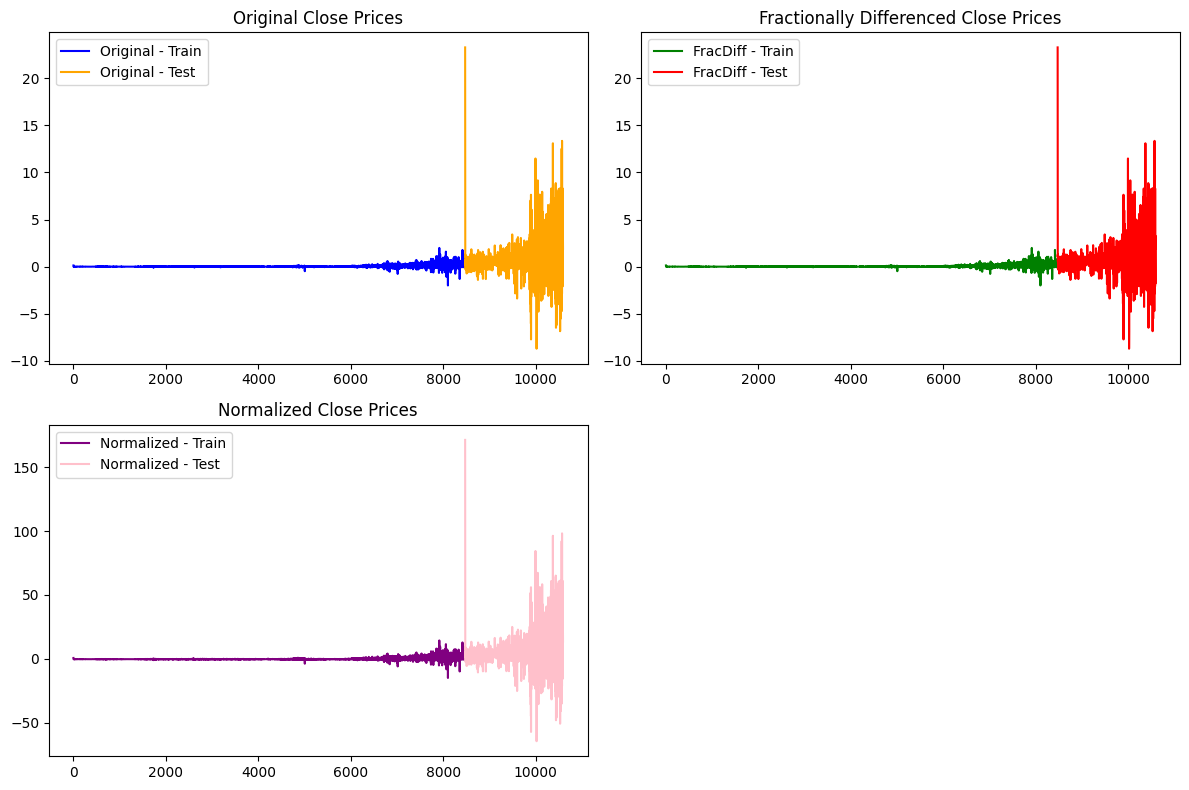

In [9]:
# Prepare the data for plotting
original_train_close = train['Close']
original_test_close = test['Close']

# Converting the normalized data back to DataFrame for easy plotting
X_train_df = pd.DataFrame(X_train, columns=train.columns, index=train.index)
X_test_df = pd.DataFrame(X_test, columns=test.columns, index=test.index)

plt.figure(figsize=(12, 8))

# Plot original Close prices for train and test sets
plt.subplot(2, 2, 1)
plt.plot(original_train_close.index, original_train_close, label='Original - Train', color='blue')
plt.plot(original_test_close.index, original_test_close, label='Original - Test', color='orange')
plt.title('Original Close Prices')
plt.legend()

# Plot fractionally differenced Close prices for train and test sets
plt.subplot(2, 2, 2)
plt.plot(train.index, train['Close'], label='FracDiff - Train', color='green')
plt.plot(test.index, test['Close'], label='FracDiff - Test', color='red')
plt.title('Fractionally Differenced Close Prices')
plt.legend()

# Plot normalized Close prices for train and test sets
plt.subplot(2, 2, 3)
plt.plot(X_train_df.index, X_train_df['Close'], label='Normalized - Train', color='purple')
plt.plot(X_test_df.index, X_test_df['Close'], label='Normalized - Test', color='pink')
plt.title('Normalized Close Prices')
plt.legend()

plt.tight_layout()
plt.show()